In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations, save_model_GCN
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork

from args import *
from utils import *

from tqdm import tqdm
from IPython.display import clear_output as ipyclear

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset

In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

Model training parameters

In [3]:
model_name = "CEAL"
model_network = model_name + "Network"
model_args = args[model_name]

In [4]:
def save_result_data(
    all_args,
    epoch,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    device,
    result_path,
    regression_title="Model Regression",
    checkpoint_name="checkpoint.pt",
    save_split=100,
    training=False,
    *args,
    **kwargs
):
    if epoch % save_split != 0 and training is True:
        return

    print("Saving data...")

    checkpoint = torch.load(osp.join(result_path, checkpoint_name), map_location=get_device())

    model = checkpoint["model"]

    save_hyper_parameter(all_args, result_path)
    save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
    test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

    # Reverse normalization of test_out and y
    min, max = get_data_scale(all_args)
    test_y = reverse_min_max_scalar_1d(test_y, min, max)
    test_out = reverse_min_max_scalar_1d(test_out, min, max)
    loss = (test_out.squeeze() - test_y).abs().mean()
    print("MAE loss: ", loss.item())

    # save results
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
    save_regression_result(test_out, test_y, result_path)
    plot_regression_result(regression_title, result_path, plotfilename="regression_figure.jpeg")

In [5]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()
# device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
deg = generate_deg(train_dataset).float()
deg = deg.to(device)
model = CEALNetwork(deg, in_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=model_args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode=model_args["sche_mode"], factor=model_args["sche_factor"], patience=model_args["sche_patience"], min_lr=model_args["sche_min_lr"]
)

25092 8364 8363


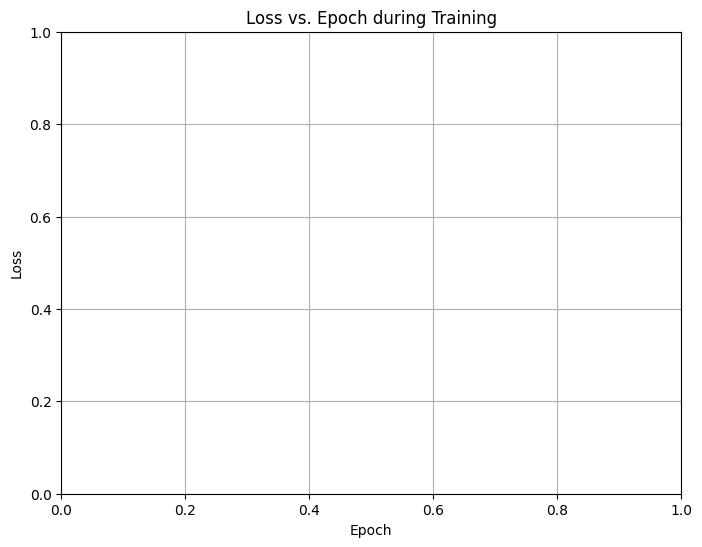

In [6]:
result_path = createResultFolder(osp.join("./results", model_name))
test_best_loss = None
epoch = None

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Model training

epoch:49 train:0.0198 valid:0.0185 test:0.0185 lr:0.01 best_test:0.0185:   0%|          | 50/10001 [05:06<17:29:18,  6.33s/it]

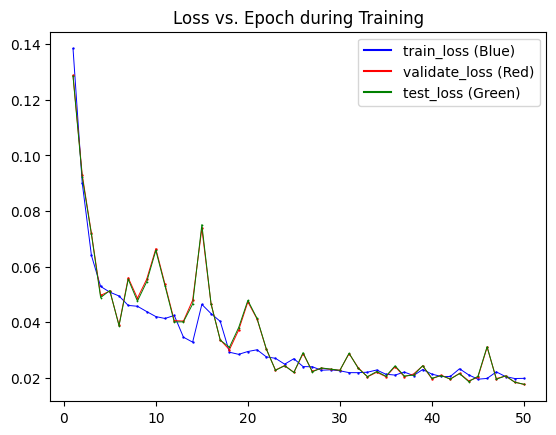

epoch:91 train:0.0143 valid:0.0165 test:0.0163 lr:0.01 best_test:0.013:   1%|          | 92/10001 [09:28<17:25:31,  6.33s/it] 

In [7]:
epoch_start = 0 if epoch is None else epoch
epoch = epoch_start - 1
epochs = model_args["epochs"]

pbar = tqdm(total=(epochs + 1))
pbar.update(epoch_start + 1)

for epoch in range(epoch_start + 1, epochs + 1):
    save_result_data(
        args,
        epoch,
        train_losses,
        val_losses,
        test_losses,
        test_loader,
        test_dataset,
        device,
        result_path,
        regression_title=model_name,
        save_split=100,
        training=True,
    )

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=50)

    # save best model
    if test_best_loss is None or test_loss < test_best_loss:
        test_best_loss = test_loss
        save_model_GCN(epoch, model, optimizer, scheduler, result_path)

    progress_msg = (
        "epoch:"
        + str(epoch)
        + " train:"
        + str(round(train_loss, 4))
        + " valid:"
        + str(round(val_loss, 4))
        + " test:"
        + str(round(test_loss, 4))
        + " lr:"
        + str(round(current_lr, 8))
        + " best_test:"
        + str(round(test_best_loss, 4))
    )
    pbar.set_description(progress_msg)
    pbar.update(1)
    
    torch.cuda.empty_cache()
 
pbar.close()

Save model, results and checkpoint

In [ ]:
save_model_GCN(epoch - 1, model, optimizer, scheduler, result_path)
save_result_data(args, epoch, train_losses, val_losses, test_losses, test_loader, test_dataset, device, result_path, regression_title=model_name)